In [ ]:
# Spark init
!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz 
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/default-java"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("My Spark App").setMaster("local")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [ ]:
df_house = spark.read.csv("/content/drive/MyDrive/data/housing_final.csv", inferSchema=True, header=True)

In [ ]:
df_house.show()

+-----+------------+------------+-----------+-------------+----------------+----+-----+--------+--------------------------+
|Sales|DollarVolume|AveragePrice|MedianPrice|TotalListings|MonthlyInventory|Year|Month|City/MSA|YearlyCrimesReportedByArea|
+-----+------------+------------+-----------+-------------+----------------+----+-----+--------+--------------------------+
|103.0|   4791766.0|       46522|      56214|          765|             7.4|1990|    1| Abilene|                     914.0|
| 61.0|   2945873.0|       48293|      66072|          981|            12.0|1990|    2| Abilene|                     914.0|
| 85.0|   4218975.0|       49635|      62551|         1042|            12.6|1990|    3| Abilene|                     914.0|
| 95.0|   4135730.0|       43534|      57094|         1044|            12.2|1990|    4| Abilene|                     914.0|
|106.0|   4803602.0|       45317|      56038|          971|            10.8|1990|    5| Abilene|                     914.0|
|100.0| 

In [ ]:
df_house.printSchema()

root
 |-- Sales: double (nullable = true)
 |-- DollarVolume: double (nullable = true)
 |-- AveragePrice: integer (nullable = true)
 |-- MedianPrice: integer (nullable = true)
 |-- TotalListings: integer (nullable = true)
 |-- MonthlyInventory: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- City/MSA: string (nullable = true)
 |-- YearlyCrimesReportedByArea: double (nullable = true)



In [ ]:
from pyspark.ml.feature import StringIndexer

In [ ]:
indexer = StringIndexer(inputCol = 'City/MSA', outputCol = 'city_idx')
df = indexer.fit(df_house).transform(df_house)
df.show()

+-----+------------+------------+-----------+-------------+----------------+----+-----+--------+--------------------------+--------+
|Sales|DollarVolume|AveragePrice|MedianPrice|TotalListings|MonthlyInventory|Year|Month|City/MSA|YearlyCrimesReportedByArea|city_idx|
+-----+------------+------------+-----------+-------------+----------------+----+-----+--------+--------------------------+--------+
|103.0|   4791766.0|       46522|      56214|          765|             7.4|1990|    1| Abilene|                     914.0|     0.0|
| 61.0|   2945873.0|       48293|      66072|          981|            12.0|1990|    2| Abilene|                     914.0|     0.0|
| 85.0|   4218975.0|       49635|      62551|         1042|            12.6|1990|    3| Abilene|                     914.0|     0.0|
| 95.0|   4135730.0|       43534|      57094|         1044|            12.2|1990|    4| Abilene|                     914.0|     0.0|
|106.0|   4803602.0|       45317|      56038|          971|          

In [ ]:
df.columns

['Sales',
 'DollarVolume',
 'AveragePrice',
 'MedianPrice',
 'TotalListings',
 'MonthlyInventory',
 'Year',
 'Month',
 'City/MSA',
 'YearlyCrimesReportedByArea',
 'city_idx']

In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix

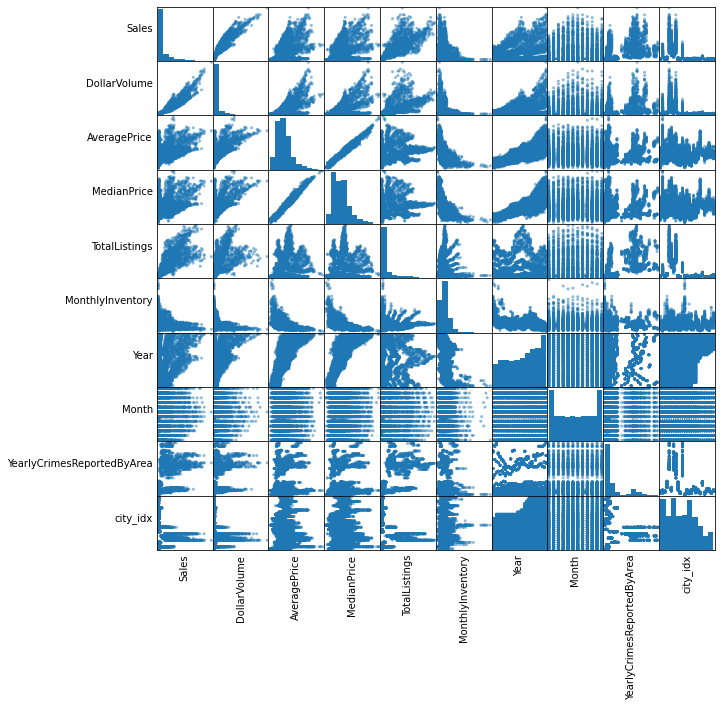

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [ ]:
import six

In [ ]:
for i in df.columns:
    if not( isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MedianPrice for ", i, df.stat.corr('MedianPrice',i))

Correlation to MedianPrice for  Sales 0.4189380307745777
Correlation to MedianPrice for  DollarVolume 0.5416708530093095
Correlation to MedianPrice for  AveragePrice 0.9798320225029512
Correlation to MedianPrice for  MedianPrice 1.0
Correlation to MedianPrice for  TotalListings 0.1779888649917788
Correlation to MedianPrice for  MonthlyInventory -0.5203159144436832
Correlation to MedianPrice for  Year 0.7900672017310437
Correlation to MedianPrice for  Month 0.0545017180044795
Correlation to MedianPrice for  YearlyCrimesReportedByArea 0.1272429745105624
Correlation to MedianPrice for  city_idx -0.02879406369296482


In [ ]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [ ]:
assembler = VectorAssembler(inputCols=['Sales', 'TotalListings', 'MonthlyInventory', 'Year', 'Month', 'YearlyCrimesReportedByArea', 'city_idx'],\
                            outputCol='features')

In [ ]:
assembler

VectorAssembler_0b6779336352

In [ ]:
output = assembler.transform(df)

In [ ]:
output.show()

+-----+------------+------------+-----------+-------------+----------------+----+-----+--------+--------------------------+--------+--------------------+
|Sales|DollarVolume|AveragePrice|MedianPrice|TotalListings|MonthlyInventory|Year|Month|City/MSA|YearlyCrimesReportedByArea|city_idx|            features|
+-----+------------+------------+-----------+-------------+----------------+----+-----+--------+--------------------------+--------+--------------------+
|103.0|   4791766.0|       46522|      56214|          765|             7.4|1990|    1| Abilene|                     914.0|     0.0|[103.0,765.0,7.4,...|
| 61.0|   2945873.0|       48293|      66072|          981|            12.0|1990|    2| Abilene|                     914.0|     0.0|[61.0,981.0,12.0,...|
| 85.0|   4218975.0|       49635|      62551|         1042|            12.6|1990|    3| Abilene|                     914.0|     0.0|[85.0,1042.0,12.6...|
| 95.0|   4135730.0|       43534|      57094|         1044|            12.2|

In [ ]:
final = output.select('features', 'MedianPrice')

In [ ]:
final.show(truncate=False)

+---------------------------------------+-----------+
|features                               |MedianPrice|
+---------------------------------------+-----------+
|[103.0,765.0,7.4,1990.0,1.0,914.0,0.0] |56214      |
|[61.0,981.0,12.0,1990.0,2.0,914.0,0.0] |66072      |
|[85.0,1042.0,12.6,1990.0,3.0,914.0,0.0]|62551      |
|[95.0,1044.0,12.2,1990.0,4.0,914.0,0.0]|57094      |
|[106.0,971.0,10.8,1990.0,5.0,914.0,0.0]|56038      |
|[100.0,964.0,10.5,1990.0,6.0,914.0,0.0]|52517      |
|[121.0,983.0,10.3,1990.0,7.0,914.0,0.0]|59911      |
|[137.0,909.0,9.0,1990.0,8.0,914.0,0.0] |58502      |
|[123.0,841.0,8.1,1990.0,9.0,914.0,0.0] |55246      |
|[122.0,806.0,7.7,1990.0,10.0,914.0,0.0]|49524      |
|[103.0,765.0,7.3,1990.0,11.0,914.0,0.0]|56214      |
|[82.0,704.0,6.8,1990.0,12.0,914.0,0.0] |62903      |
|[81.0,699.0,6.9,1991.0,1.0,870.0,0.0]  |58414      |
|[76.0,681.0,6.6,1991.0,2.0,870.0,0.0]  |48820      |
|[91.0,698.0,6.8,1991.0,3.0,870.0,0.0]  |54718      |
|[94.0,696.0,6.8,1991.0,4.0,

In [ ]:
train, test = final.randomSplit([0.8, 0.2])

In [ ]:
train.show()

+--------------------+-----------+
|            features|MedianPrice|
+--------------------+-----------+
|[17.0,377.0,11.9,...|      65193|
|[17.0,377.0,21.6,...|      65193|
|[22.0,351.0,10.9,...|      68111|
|[22.0,894.0,21.6,...|      45131|
|[23.0,632.0,7.3,2...|      75953|
|[23.0,1127.0,22.3...|      43908|
|[27.0,245.0,5.9,1...|      78033|
|[27.0,418.0,13.1,...|      69571|
|[27.0,562.0,10.9,...|      69766|
|[27.0,572.0,10.7,...|      61286|
|[28.0,234.0,5.4,1...|      76866|
|[28.0,282.0,7.5,1...|      67139|
|[28.0,415.0,13.9,...|      54007|
|[28.0,592.0,10.7,...|      66238|
|[28.0,592.0,21.2,...|      66238|
|[29.0,201.0,5.0,1...|      65193|
|[29.0,269.0,7.1,1...|      62275|
|[29.0,281.0,7.2,1...|      62275|
|[29.0,292.0,5.6,2...|      84940|
|[29.0,668.0,13.2,...|      59305|
+--------------------+-----------+
only showing top 20 rows



Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
lr = LinearRegression(featuresCol = 'features', labelCol='MedianPrice', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [10.728746314079904,-0.8013307328105947,-1568.8961489273383,4231.423686449378,595.8045634756928,-0.11571623019185548,-1039.5124707425193]
Intercept: -8351169.332897272


In [ ]:
coef = lr_model.coefficients
inter = lr_model.intercept

In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 24299.620812
r2: 0.775865


In [ ]:
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","MedianPrice","features").show(truncate = False)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MedianPrice",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----------+----------------------------------------+
|prediction        |MedianPrice|features                                |
+------------------+-----------+----------------------------------------+
|16627.42180417478 |57355      |[20.0,1092.0,27.8,1990.0,5.0,43.0,11.0] |
|53255.0657143835  |65290      |[25.0,290.0,7.4,1992.0,1.0,689.0,13.0]  |
|47824.669786276296|64178      |[27.0,569.0,10.7,1991.0,1.0,495.0,9.0]  |
|70295.70567333698 |72489      |[28.0,203.0,4.7,1995.0,1.0,616.0,13.0]  |
|127074.19643089361|117722     |[29.0,378.0,6.2,2009.0,1.0,431.0,13.0]  |
|60671.84897136688 |60329      |[30.0,259.0,6.9,1992.0,12.0,689.0,13.0] |
|52217.06512439065 |64220      |[30.0,320.0,8.8,1991.0,10.0,706.0,13.0] |
|150926.264121918  |122000     |[30.0,454.0,7.9,2017.0,1.0,478.0,20.0]  |
|57761.11494839378 |65049      |[30.0,559.0,10.5,1990.0,12.0,638.0,2.0] |
|70766.00553013012 |63929      |[31.0,204.0,4.8,1995.0,2.0,616.0,13.0]  |
|42930.16474346444 |57049      |[31.0,

In [ ]:
#----------------------------------------------------------------------------------------------------------------------------------------------------

Decision Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'MedianPrice')
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="MedianPrice", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 12321


In [ ]:
dt_predictions.show()

+--------------------+-----------+------------------+
|            features|MedianPrice|        prediction|
+--------------------+-----------+------------------+
|[169.0,1.2,2019.0...|     239900|       211161.4125|
|[193.0,5.0,1992.0...|      62956| 71155.17886178862|
|[194.0,1.4,2018.0...|     204500|       211161.4125|
|[194.0,5.1,1992.0...|      67917| 71155.17886178862|
|[196.0,1.5,2018.0...|     222550|       211161.4125|
|[199.0,5.0,1996.0...|      72683| 86055.99516908213|
|[200.0,2.0,2013.0...|     155400|168986.52777777778|
|[203.0,1.8,2018.0...|     195000|       211161.4125|
|[203.0,2.4,2020.0...|     200000|183101.21582733814|
|[208.0,5.1,1996.0...|      66166| 86055.99516908213|
|[210.0,1.7,2013.0...|     144900|150944.45502645502|
|[210.0,3.2,2020.0...|     155000|145425.94957983194|
|[213.0,1.5,2018.0...|     206000|       211161.4125|
|[215.0,2.2,2014.0...|     174900|168986.52777777778|
|[217.0,5.1,1996.0...|      81146| 86055.99516908213|
|[218.0,3.4,2012.0...|     1

In [ ]:
accuracy = dt_evaluator.evaluate(dt_predictions)
print(accuracy)

12321.039488564791


In [ ]:
#75k to 125k

In [ ]:
#88k to 112k

In [ ]:
#92k to 108k

In [ ]:
#----------------------------------------------------------------------------------------------------------------------------------------------------

Gradient Boosted Tree Regression

In [ ]:
from pyspark.ml.regression import GBTRegressor

In [ ]:
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'MedianPrice')
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'MedianPrice', 'features').show(5)

+------------------+-----------+--------------------+
|        prediction|MedianPrice|            features|
+------------------+-----------+--------------------+
| 213726.2614141457|     239900|[169.0,1.2,2019.0...|
|  69607.7504770557|      62956|[193.0,5.0,1992.0...|
| 211355.3451607007|     204500|[194.0,1.4,2018.0...|
| 67330.92149487065|      67917|[194.0,5.1,1992.0...|
|208480.66673581427|     222550|[196.0,1.5,2018.0...|
+------------------+-----------+--------------------+
only showing top 5 rows



In [ ]:
gbt_evaluator = RegressionEvaluator(
    labelCol="MedianPrice", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("RMSE on test data = %g" % rmse)

RMSE on test data = 8475.35


In [ ]:
gbt_predictions.show()

+--------------------+-----------+------------------+
|            features|MedianPrice|        prediction|
+--------------------+-----------+------------------+
|[169.0,1.2,2019.0...|     239900| 213726.2614141457|
|[193.0,5.0,1992.0...|      62956|  69607.7504770557|
|[194.0,1.4,2018.0...|     204500| 211355.3451607007|
|[194.0,5.1,1992.0...|      67917| 67330.92149487065|
|[196.0,1.5,2018.0...|     222550|208480.66673581427|
|[199.0,5.0,1996.0...|      72683| 81015.29859751355|
|[200.0,2.0,2013.0...|     155400|165548.61818428012|
|[203.0,1.8,2018.0...|     195000|197090.38281530753|
|[203.0,2.4,2020.0...|     200000| 216842.7574880936|
|[208.0,5.1,1996.0...|      66166| 80444.07384754914|
|[210.0,1.7,2013.0...|     144900|138864.93451508207|
|[210.0,3.2,2020.0...|     155000| 165602.7553902294|
|[213.0,1.5,2018.0...|     206000|208552.39872769327|
|[215.0,2.2,2014.0...|     174900| 165446.3294595193|
|[217.0,5.1,1996.0...|      81146| 82156.63279590737|
|[218.0,3.4,2012.0...|     1